#Tomato Leaves Disease Classification - TL - InceptionV3

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/diseases.jpg" width="600">

In [1]:
from tensorflow.keras.layers import Conv2D,Dense,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

In [2]:
#capture
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/dataset.zip
!unzip --qq dataset.zip

--2024-02-01 19:56:52--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/dataset.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.142.106, 52.95.143.10, 52.95.148.82, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.142.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77386380 (74M) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  73.80M  21.2MB/s    in 3.5s    

2024-02-01 19:56:56 (21.2 MB/s) - ‘dataset.zip’ saved [77386380/77386380]



In [3]:
dataset = 'dataset'
image_size = (150, 150)
batch_size = 32
ch=3

In [4]:
# ## No Augmentation
# training_set = image_dataset_from_directory(dataset,
#                                             validation_split=0.2,
#                                             subset="training",
#                                             seed=667,
#                                             image_size=image_size,
#                                             batch_size=batch_size,
#                                             label_mode = 'categorical'
#                                             )

# validation_set = image_dataset_from_directory(dataset,
#                                                 validation_split=0.2,
#                                                 subset="validation",
#                                                 seed=667,
#                                                 image_size=image_size,
#                                                 batch_size=batch_size,
#                                                 label_mode = 'categorical'
#                                                 )

In [5]:
# folder names in alphabetic order== Keras' class_names
class_names = ['TomatoBacterial_spot',
                'TomatoEarly_blight',
                'TomatoLate_blight',
                'TomatoLeaf_Mold',
                'TomatoSeptoria_leaf_spot',
                'TomatoSpider_mites Two-spotted_spider_mite',
                'TomatoTarget_Spot',
                'TomatoYellow_Leaf_Curl_Virus',
                'Tomatohealthy',
                'Tomatomosaic_virus']
class_names

['TomatoBacterial_spot',
 'TomatoEarly_blight',
 'TomatoLate_blight',
 'TomatoLeaf_Mold',
 'TomatoSeptoria_leaf_spot',
 'TomatoSpider_mites Two-spotted_spider_mite',
 'TomatoTarget_Spot',
 'TomatoYellow_Leaf_Curl_Virus',
 'Tomatohealthy',
 'Tomatomosaic_virus']

In [6]:
num_classes = len(class_names)
num_classes

10

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

## With Augmentation

In [8]:
datagenerator  = ImageDataGenerator(
                                    preprocessing_function=preprocess_input,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.2 #prepare also for validtion dataset!!!!!!!!
                                    )

training_set = datagenerator.flow_from_directory(dataset,
                                                subset="training",
                                                seed=667,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode = 'categorical',
                                                shuffle=False
                                                 )

validation_set = datagenerator.flow_from_directory(dataset,
                                                    subset="validation",
                                                    seed=667,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle=False
                                                    )

Found 3670 images belonging to 10 classes.
Found 915 images belonging to 10 classes.


In [9]:
model = Sequential()

pretrained_model = InceptionV3(include_top=False,
                                input_shape=(image_size[0],image_size[1],ch),
                                pooling='avg',
                                classes=num_classes,
                                weights='imagenet'
                                )

for layer in pretrained_model.layers:
    layer.trainable = False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 22857002 (87.19 MB)
Trainable params: 1054218 (4.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


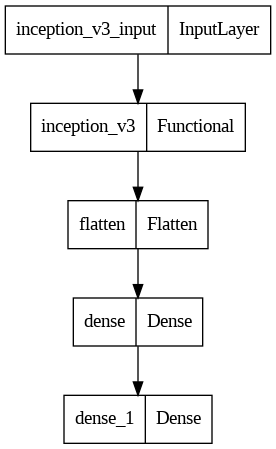

In [10]:
plot_model(model)

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy']
              )

In [ ]:
file_path="weights_best.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early] #early

history = model.fit(training_set,
                    validation_data=validation_set,
                    epochs=10,
                    steps_per_epoch=len(training_set),
                    validation_steps=len(validation_set),
                    callbacks=callbacks_list
                    )

Epoch 1/10
115/115 [==============================] - ETA: 0s - loss: 3.2880 - accuracy: 0.1771
Epoch 1: val_accuracy improved from -inf to 0.26120, saving model to weights_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 46s 321ms/step - loss: 3.2880 - accuracy: 0.1771 - val_loss: 2.0876 - val_accuracy: 0.2612
Epoch 2/10
115/115 [==============================] - ETA: 0s - loss: 1.9387 - accuracy: 0.3251
Epoch 2: val_accuracy improved from 0.26120 to 0.32459, saving model to weights_best.h5
115/115 [==============================] - 36s 312ms/step - loss: 1.9387 - accuracy: 0.3251 - val_loss: 1.7945 - val_accuracy: 0.3246
Epoch 3/10
115/115 [==============================] - ETA: 0s - loss: 1.6324 - accuracy: 0.4248
Epoch 3: val_accuracy improved from 0.32459 to 0.42077, saving model to weights_best.h5
115/115 [==============================] - 32s 282ms/step - loss: 1.6324 - accuracy: 0.4248 - val_loss: 1.6658 - val_accuracy: 0.4208
Epoch 4/10
115/115 [==============================] - ETA: 0s - loss: 1.4367 - accuracy: 0.5123
Epoch 4: val_accuracy improved from 0.42077 to 0.47322, saving model to weights_best.h5
115/115 [==============================] - 32s

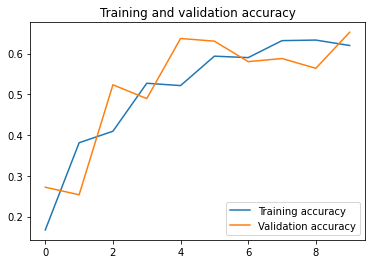

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

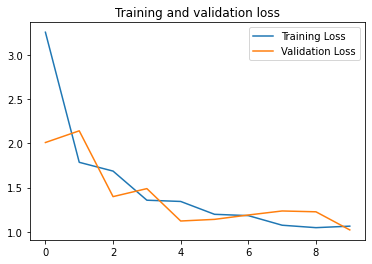

In [ ]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
model.save('InceptionV3.h5')

In [ ]:
model = load_model('InceptionV3.h5')

In [ ]:
#915/batch_size almost 29
#validation_set[29][1] #30 out of range because 0 index

In [ ]:
res =[]
for i in range(0,29):
    #print(np.argmax(validation_set[i][1],axis=1))
    res.append(np.argmax(validation_set[i][1],axis=1))

y_test = []
for sublist in res: #explode the list of lists
    y_test.extend(sublist)
y_test = np.array(y_test)
#y_test

In [ ]:
predict_x = model.predict(validation_set)
y_pred = np.argmax(predict_x,axis=1)

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

print(classification_report(y_pred, y_test, target_names=class_names))

                                            precision    recall  f1-score   support

                      TomatoBacterial_spot       0.78      0.63      0.69       105
                        TomatoEarly_blight       0.49      0.52      0.51        90
                         TomatoLate_blight       0.78      0.56      0.65       128
                           TomatoLeaf_Mold       0.60      0.63      0.61        89
                  TomatoSeptoria_leaf_spot       0.43      0.66      0.52        56
TomatoSpider_mites Two-spotted_spider_mite       0.55      0.59      0.57        81
                         TomatoTarget_Spot       0.33      0.58      0.42        52
              TomatoYellow_Leaf_Curl_Virus       0.95      0.56      0.71       165
                             Tomatohealthy       0.70      0.94      0.80        71
                        Tomatomosaic_virus       0.66      0.76      0.71        78

                                  accuracy                           0.63 

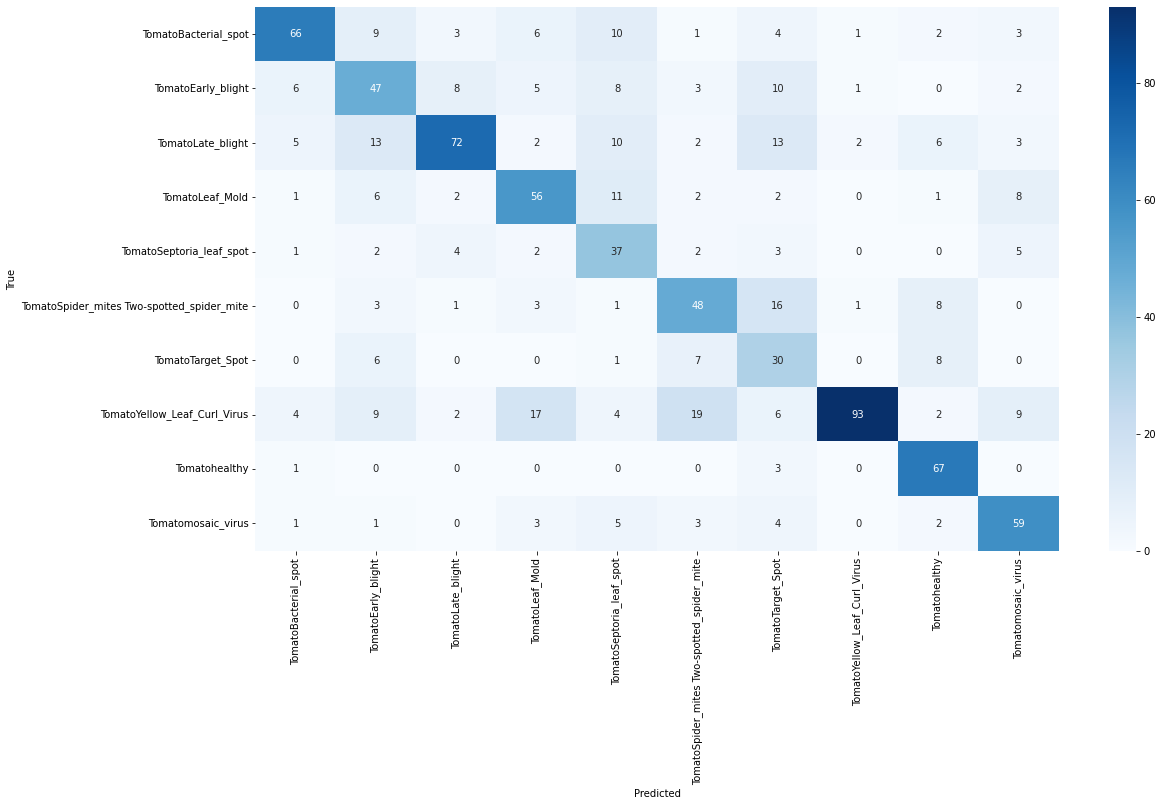

In [ ]:
cm = pd.crosstab(y_pred,y_test,
                 rownames = ['True'],
                 colnames = ['Predicted'],
                 )

plt.figure(figsize=(18,10))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g',xticklabels=class_names, yticklabels=class_names);

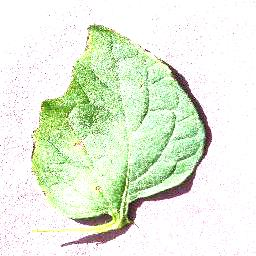

test/TomatoTarget_Spot-002.JPG


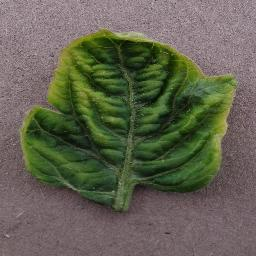

test/TomatoYellow_Leaf_Curl_Virus-002.JPG


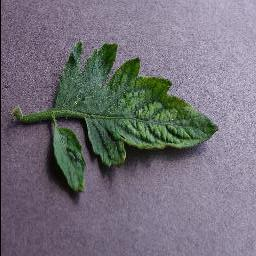

test/Tomatomosaic_virus-001.JPG


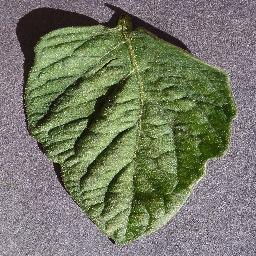

test/Tomatohealthy-001.JPG


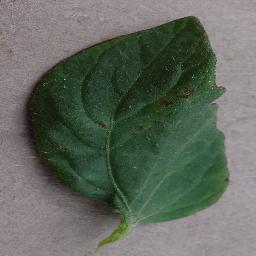

test/TomatoBacterial_spot-001.JPG


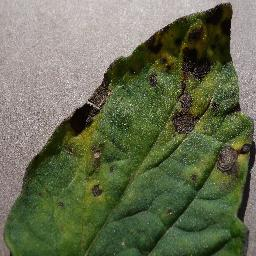

test/TomatoEarly_blight-001.JPG


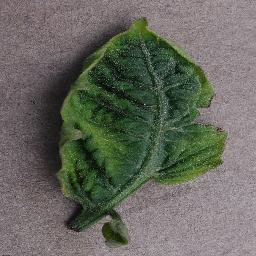

test/TomatoYellow_Leaf_Curl_Virus-001.JPG


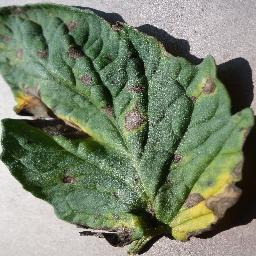

test/TomatoEarly_blight-002.JPG


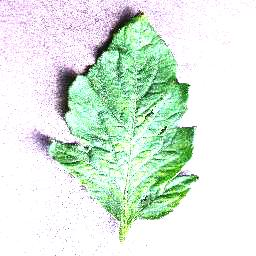

test/Tomatomosaic_virus-002.JPG


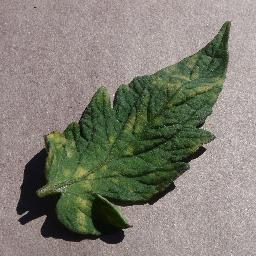

test/TomatoLeaf_Mold-001.JPG


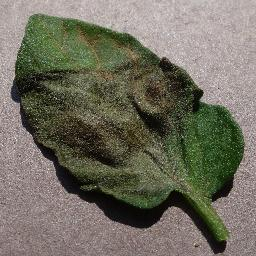

test/TomatoLate_blight-001.JPG


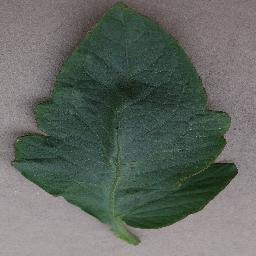

test/TomatoBacterial_spot-002.JPG


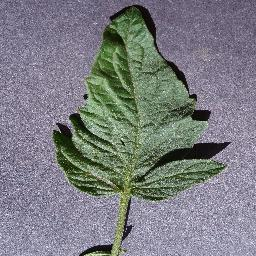

test/Tomatohealthy-002.JPG


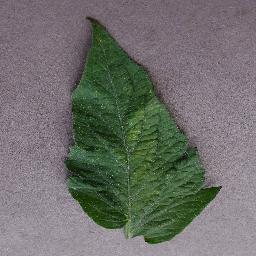

test/TomatoSpider_mites Two-spotted_spider_mite-002.JPG


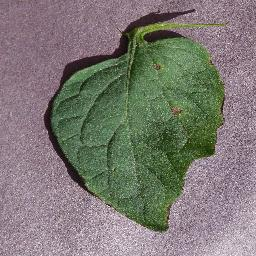

test/TomatoTarget_Spot-001.JPG


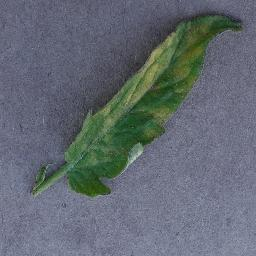

test/TomatoLeaf_Mold-002.JPG


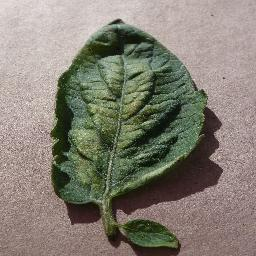

test/TomatoSpider_mites Two-spotted_spider_mite-001.JPG


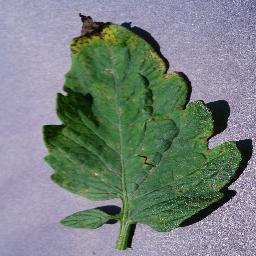

test/TomatoSeptoria_leaf_spot-001.JPG


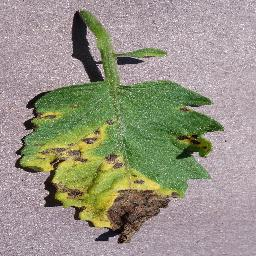

test/TomatoSeptoria_leaf_spot-002.JPG


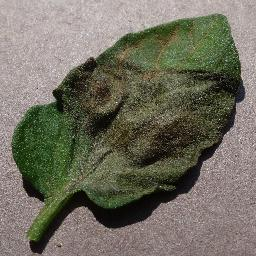

test/TomatoLate_blight-002.JPG


In [ ]:
import glob
from IPython.display import Image, display
for imageName in glob.glob('test/*.*'): #estensione file
    display(Image(filename=imageName))
    print(imageName)

In [ ]:
import os
lista = os.listdir('test/') #
lista

['TomatoTarget_Spot-002.JPG',
 'TomatoYellow_Leaf_Curl_Virus-002.JPG',
 'Tomatomosaic_virus-001.JPG',
 'Tomatohealthy-001.JPG',
 'TomatoBacterial_spot-001.JPG',
 'TomatoEarly_blight-001.JPG',
 'TomatoYellow_Leaf_Curl_Virus-001.JPG',
 'TomatoEarly_blight-002.JPG',
 'Tomatomosaic_virus-002.JPG',
 'TomatoLeaf_Mold-001.JPG',
 'TomatoLate_blight-001.JPG',
 'TomatoBacterial_spot-002.JPG',
 'Tomatohealthy-002.JPG',
 'TomatoSpider_mites Two-spotted_spider_mite-002.JPG',
 'TomatoTarget_Spot-001.JPG',
 'TomatoLeaf_Mold-002.JPG',
 'TomatoSpider_mites Two-spotted_spider_mite-001.JPG',
 'TomatoSeptoria_leaf_spot-001.JPG',
 'TomatoSeptoria_leaf_spot-002.JPG',
 'TomatoLate_blight-002.JPG']

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

## training_set.class_indices
classes = {0:"TomatoBacterial_spot",
           1:"TomatoEarly_blight",
           2:"TomatoLate_blight",
           3:"TomatoLeaf_Mold",
           4:"TomatoSeptoria_leaf_spot",
           5:"TomatoSpider_mites",
           6:"TomatoTarget_Spot",
           7:"TomatoYellow_Leaf_Curl_Virus",
           8:"Tomatohealthy",
           9:"Tomatomosaic_virus",
           }


finale=[]
name = []
res = []


for i in lista:
    path = '/content/test/' + i
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x/=255.0
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    pred = model.predict(images, batch_size=10)
    print(pred)
    result = np.argmax(pred, axis=-1)[0]
    print(result)
    name.append(i)
    finale.append(result)
    res.append(classes[result])

finale
print(name)
print(res)

[[0.24407521 0.19726643 0.16612941 0.03097484 0.12453289 0.05560407
  0.04840754 0.12597367 0.00080116 0.00623481]]
0
[[2.0223843e-07 1.1288649e-06 1.3554960e-06 1.1775098e-05 1.7089144e-07
  8.2053637e-05 2.1697795e-06 9.9989688e-01 4.3195925e-08 4.1382600e-06]]
7
[[3.2820932e-05 3.0172777e-03 1.1844921e-02 3.6888190e-02 4.7933357e-03
  1.0884842e-02 1.6826423e-04 4.0080762e-01 6.9047266e-05 5.3149360e-01]]
9
[[0.00180625 0.00757442 0.01826187 0.02202361 0.00333739 0.23139551
  0.11979133 0.00791176 0.5870361  0.00086181]]
8
[[0.49684379 0.28947377 0.09552794 0.0174803  0.03644392 0.01553377
  0.02780319 0.01800652 0.00162009 0.00126673]]
0
[[4.5194589e-02 2.5919065e-01 3.0677038e-01 5.5297010e-02 3.0885366e-01
  6.1335443e-03 3.6729819e-03 9.7821699e-03 7.2403105e-05 5.0326088e-03]]
4
[[0.1339336  0.04743293 0.03463349 0.08084241 0.07822389 0.21322523
  0.04360983 0.36059806 0.00170871 0.00579188]]
7
[[1.1883781e-01 6.9248289e-01 5.1689867e-02 2.8541883e-02 7.4554823e-02
  5.3327372e